<H1 style="text-align: center;">Lots of struggle, Plenty of progress</H1>

<H3 style="text-align: center;">“IF THERE IS NO STRUGGLE, THERE IS NO PROGRESS” - FREDERICK DOUGLASS
</H3>


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import tree
# import graphviz
from sklearn import metrics 

%matplotlib inline

In [2]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [3]:

raw = pd.read_csv('../train.csv')
checks = raw
working_df = raw
print("Original data frame shape:",raw.shape)


Original data frame shape: (1460, 81)


In [4]:
df_features = raw.columns.tolist()
# df_features

Getting Started ^^^^^^

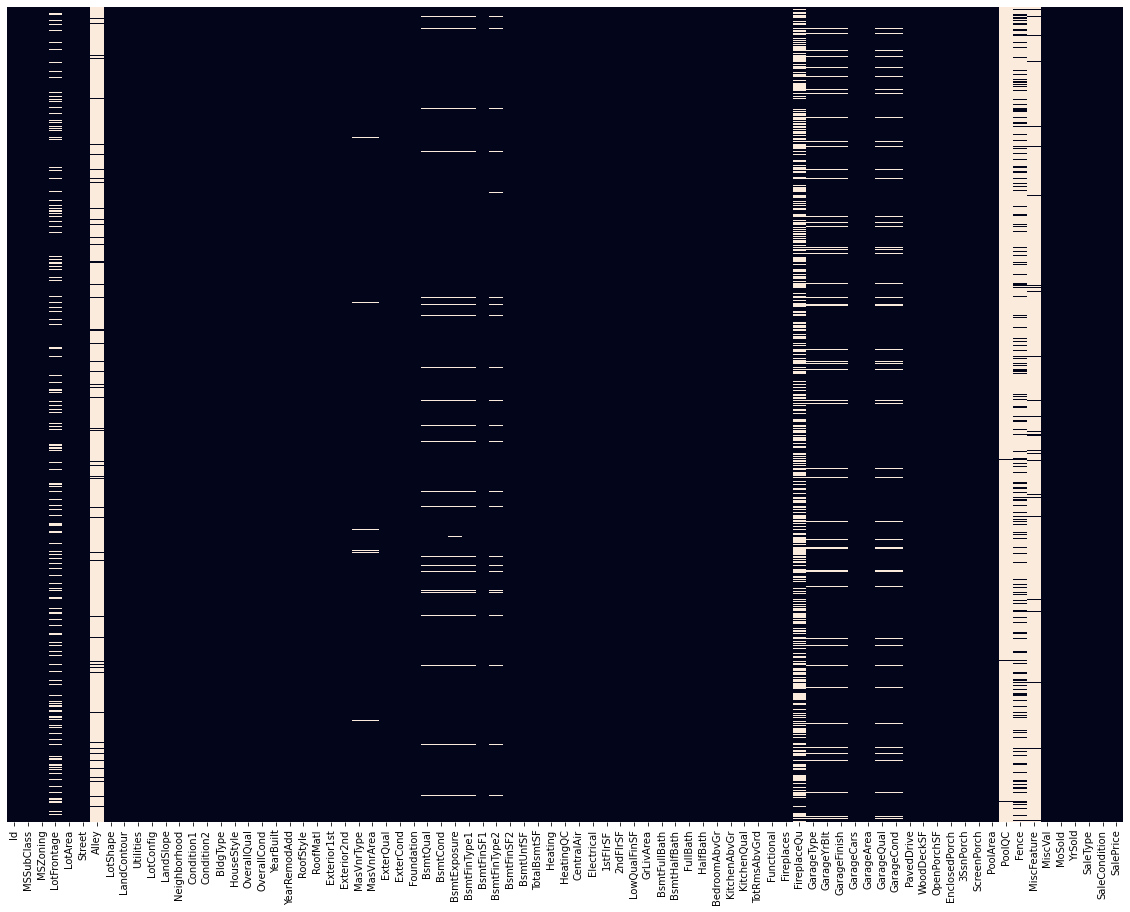

In [5]:
def check_for_nulls(df):
    heatmap, ax2 = plt.subplots(figsize = (20,15))
    # ax2=sns.heatmap(raw.isnull(),yticklabels=False,cbar=False,cmap='viridis') #cmap='YlGnBu
    ax2=sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
    
check_for_nulls(working_df)

In [6]:
# lis = ["LotFrontage","Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
# "GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]
# a=[]
# for i in lis:
#     if checks[i].dtype == 'int64' or checks[i].dtype == 'float64':
#         a.append(i+ ' '+str(checks[i].dtype))
        
# print(a)

# ['LotFrontage', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']

In [7]:
checks[["LotFrontage","Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
"GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
checks['TotalBsmtSF'].isna().sum()

0

In [9]:
# Not every N/a is equal in this dataset.
# fixNa() relabels the n/a's that actually mean "not included" and drops the true N/a's 

def fixNa(df,state):
    ### correct mislabled NAs
    
    naMeanings = [
        "LotFrontage","Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
        "GarageType","GarageYrBlt","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"] 
        
    for col in naMeanings:
        if col == "LotFrontage":
            df['LotFrontage'].fillna(value=df['LotFrontage'].mean(), inplace=True)
        elif col == 'GarageYrBlt':
            # df['GarageYrBlt'].fillna(value=0, inplace=True)
            # checks['GarageYrBlt'].fillna(value=checks['GarageYrBlt'].mean(), inplace=True)
            df['GarageYrBlt'].fillna(value=df['GarageYrBlt'].mean(), inplace=True)

        else:
            df[col].fillna("notIncluded", inplace=True)
            # df[col].fillna(0, inplace=True)
    
    # df["MasVnrArea"].fillna(value=df['MasVnrArea'].mean(), inplace=True)
    # df["GarageArea"].fillna(value=df['GarageArea'].mean(), inplace=True)
    # df["GarageCars"].fillna(value=df['GarageCars'].mean(), inplace=True)
    # df["Functional"].fillna(value="Typ", inplace=True)
    # df["MSZoning"].fillna(value="RM", inplace=True)
    ## need to bucket categories to get rid of the problem of not predicting on the whole dataset
    df.dropna(axis=0, inplace = True)  
    
    
    return df

In [10]:
x = checks[['MasVnrArea','MasVnrType','GarageCars','GarageArea','GarageType']]

# if x.loc[x["MasVnrArea"] == None]:
    # x.loc[x["MasVnrArea"] == None, x["MasVnrType"]]
x.loc[x['GarageCars'] == np.nan]

,MasVnrArea,MasVnrType,GarageCars,GarageArea,GarageType


In [11]:
# working_df = fixNa(working_df,"t")
# check_for_nulls(working_df)

# vis

In [12]:
# sns.displot(checks, x="LotFrontage", binwidth=10)


In [13]:
# checks['GarageYrBlt'].fillna(value=checks['GarageYrBlt'].mean(), inplace=True)


In [14]:
# checks['GarageYrBlt'].isna().count()

In [15]:
# checks[['GarageYrBlt','YearBuilt']].describe()

In [16]:
# sns.relplot(x="GarageYrBlt", y="YearBuilt", hue='GarageType',data=checks)

In [17]:
# sns.displot(checks, x="GarageYrBlt", binwidth=10)


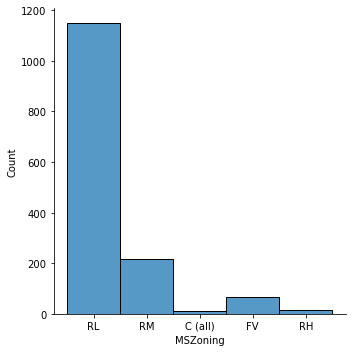

In [18]:
sns.displot(checks, x="MSZoning", binwidth=10)


In [19]:
# feature_selecting_prep() ******IMPORTANT***** >> returns df with the top NUMERICAL features to train model
# this can only be used for training... you wont have the target with real data
### NOTE ### need to store list of important features to use in testing (not the testing paired with training)
corr_val = .5

def feature_selecting_prep(df, target_value):
    numericFeatures= [
    'LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
    'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold','SalePrice'
]
    ### df of target correlation values
    # target_corr = df.corr()[[target_value]].sort_values(by=target_value, ascending=False)
    # target_corr = df[numericFeatures].corr()[[target_value]]
    target_corr = df.corr()[[target_value]]

    
    ### find features w/ corr value greater than/= to .5 w/ the target 
    top_feat = target_corr.loc[target_corr[target_value] >=corr_val] 
    
    ### find these important columns/features using the entire working data set
    ready_df = df[top_feat.index.tolist()]
    num_feat_list = ready_df.columns.tolist()
    
    return num_feat_list, target_corr.index.tolist() 
# fixNa(working_df, 'test')
# feature_selecting_prep(working_df, 'SalePrice')

In [20]:
# category_info() hold all needed info on categorical data and returns whats needed for encoding
# ordinal_feat=0

def category_info():
# removed: 'OverallQual','OverallCond', 'MSSubClass' b/c they had numbers already 
    ordinal = {'Alley':['Pave','Grvl','notIncluded'],
               'LotShape':['Reg','IR1','IR2','IR3'],
               'LandSlope':['Gtl','Mod','Sev'],
               'ExterQual':['Ex','Gd','TA','Fa','Po'],
               'ExterCond':['Ex','Gd','TA','Fa','Po'],
               'BsmtQual':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'BsmtCond':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'BsmtExposure':['Gd','Av','Mn','No','notIncluded'],
               'BsmtFinType1':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','notIncluded'],
               'BsmtFinType2': ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','notIncluded'],
               'CentralAir':['Y','N'],
               'HeatingQC':['Ex','Gd','TA','Fa','Po'],
               'KitchenQual':['Ex','Gd','TA','Fa','Po'],
               'Functional':['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],
               'FireplaceQu':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'GarageFinish':['Fin','RFn','Unf','notIncluded'], 
               'GarageQual':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'GarageCond':['Ex','Gd','TA','Fa','Po','notIncluded'],
               'PavedDrive':['Y','P','N'],
               'PoolQC':['Ex','Gd','TA','Fa','notIncluded']}
    
    nonordinal_feat = [
        'MSZoning','Street','LandContour',
        'Utilities','LotConfig','Neighborhood',
        'Condition1','Condition2','BldgType',
        'HouseStyle','RoofStyle','RoofMatl',
        'Exterior1st','Exterior2nd','MasVnrType',
        'Foundation','Heating','Electrical',
        'GarageType','Fence','MiscFeature',
        'SaleType' ,'SaleCondition'
    ]
    ohe_categories = [
        ["A","C","FV","I","RH","RL","RP","RM"],
        ["Grvl","Pave"],
        ["Lvl","Bnk","HLS","Low"],
        ["AllPub","NoSewr","NoSeWa","ELO"],
        ["LotConfig","Corner","CulDSac","FR2","FR3"],
        ["Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards","Gilbert","IDOTRR","MeadowV","Mitchel","Names","NoRidge","NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr","Timber","Veenker"],
        ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"],
        ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"],
        ["1Fam","2FmCon","Duplx","TwnhsE","TwnhsI"],
        ["1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl" ],
        ["Flat","Gable","Gambrel","Hip","Mansard","Shed"],
        ["ClyTile","CompShg","Membran","Metal","Roll","Tar&Grv","WdShake","WdShngl"],
        ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
        ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc","MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","Wd Sdng","WdShing"],
        ["BrkCmn","BrkFace","CBlock","notIncluded","Stone"],
        ["BrkTil","CBlock","PConc","Slab","Stone","Wood"],
        ["Floor","GasA","GasW","Grav","OthW","Wall"],
        ["SBrk","FuseA","FuseF","FuseP","Mix"],
        ["2Types","Attchd","Basment","BuiltIn","CarPort","Detchd","notIncluded"],
        ["GdPrv","MnPrv","GdWo","MnWw","notIncluded"],
        ["Elev","Gar2","Othr","Shed","TenC","notIncluded"],
        ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"],
        ["Normal","Abnorml","AdjLand","Alloca","Family","Partial"]
    ]
    
    # i need the category options (by rank) for the ordinal features
    ordinal_ranking = []
    ordinal_feat = []
    for i in ordinal:
        ordinal_ranking.append(ordinal[i])
        ordinal_feat.append(i)
        
    return ordinal_ranking, ordinal_feat, nonordinal_feat, ohe_categories
    

In [21]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# encode(ordinal and random) categorical features 
def encode_cats(df):

    # separtate ordinal cat and non-ordinal one
    rank, ord_feat, nonord_cat_feat, ohe_categories = category_info()
    
    ###### ORDINAL ENCODING ###########
    X = df[ord_feat]
    oc = OrdinalEncoder(categories=rank)
    ord_transformed =  oc.fit(X)
    ord_transformed = oc.transform(X)
    df[ord_feat]= ord_transformed
    
    ###### 1-HOT ENCODING ###########
    ohe = OneHotEncoder(categories=ohe_categories, handle_unknown ='ignore')
    X = df[nonord_cat_feat] # select what to encode
    ohe_transformed = ohe.fit(X)
    ohe_transformed = ohe.transform(X).toarray() # encode what you selected
    ohe_columns = ohe.get_feature_names_out() # get new column names
    enc = pd.DataFrame(ohe_transformed,columns=ohe_columns)
    # need to reset index b/c somehow without it it adds extra columns
    df = pd.concat([df.reset_index(drop=True),enc.reset_index(drop=True)],axis=1) # add columns to original dataframe
    df.drop(df[nonord_cat_feat],axis=1,inplace=True)
    # print("columns",ohe_columns)
    
    return df

# test_df = fixNa(working_df)
# test_df = encode_cats(test_df)
# test_df = encode_cats(test_df)
# test_df


In [22]:
# # feature_selecting() drops NUMERICAL columns that didn't meet the feature_selecting_prep()'s qualifications... 
# # aka it drops whatever feature_selecting_prep() didn't return
# ### NOTE ### this needs to be redone b/c I forgot to make it work for catgegorical features

# def feature_selecting(df,numbericalCatList, allNumericalFeat):
#     for feature in allNumericalFeat:
#         if feature not in numbericalCatList:
#             df.drop(feature, inplace=True, axis=1)

#     # for feature in df.columns:
#     #     if feature not in numbericalCatList:
#     #         df.drop(feature, inplace=True, axis=1)
#             # print(df.columns)
#     return df

# Training

In [23]:
def preprocessing(df,state):
    # if state == 'train':
    #     df = fixNa(df, 'train')
    #     # num_feat_list, best_num_feat = feature_selecting_prep(df, 'SalePrice')
    # else: 
    if state == "p":
        df = fixNa(df,"p")
    else:
        df = fixNa(df,"t")
        
    df = encode_cats(df)
        
    return df

In [24]:
working_df = preprocessing(working_df,"t")
working_df

,Id,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,MSZoning_A,MSZoning_C,MSZoning_FV,MSZoning_I,MSZoning_RH,MSZoning_RL,MSZoning_RP,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Lvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,Utilities_AllPub,Utilities_NoSewr,Utilities_NoSeWa,Utilities_ELO,LotConfig_LotConfig,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_Names,Neighborhood_NoRidge,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_RRNn,Condition1_RRAn,Condition1_PosN,Condition1_PosA,Condition1_RRNe,Condition1_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_RRNn,Condition2_RRAn,Condition2_PosN,Condition2_PosA,Condition2_RRNe,Condition2_RRAe,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_CBlock,MasVnrType_notIncluded,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_SBrk,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_notIncluded,Fence_GdPrv,Fence_MnPrv,Fence_GdWo,Fence_MnWw,Fence_notIncluded,MiscFeature_Elev,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_notIncluded,SaleType_WD,SaleType_CWD,SaleType_VWD,SaleType_New,SaleType_COD,SaleType_Con,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,1,60,65.0,8450,2.0,0.0,0.0,7,5,2003,2003,196.0,1.0,2.0,1.0,2.0,3.0,0.0,706,5.0,0,150,856,0.0,0.0,856,854,0,1710,1,0,2,1,3,1,1.0,8,0.0,0,5.0,2003.0,1.0,2,548,2.0,2.0,0.0,0,61,0,0,0,0,4.0,0,2,2008,2085

In [25]:
# working_df = fixNa(working_df, 'test')
# num_feat_list, best_num_feat = feature_selecting_prep(working_df, 'SalePrice')
# working_df = encode_cats(working_df)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [27]:
y_working_df = working_df['SalePrice']
X_working_df = working_df.drop(['SalePrice'], axis =1)

In [28]:
y = working_df['SalePrice']
X = working_df.drop(['SalePrice'], axis =1) # don't forget this step
# X = working_df.drop(['SalePrice', 'Id'], axis =1) # don't forget this step


# def trainModel(y,X):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression().fit(X, y)
# trainModel(y,X)

In [29]:
columns = working_df.columns.tolist()

In [30]:
train_score = regressor.score(X_train, y_train) 
test_score = regressor.score(X_test, y_test)

# Predict

# the real test data


In [31]:
test_data_raw = pd.read_csv('../test.csv')

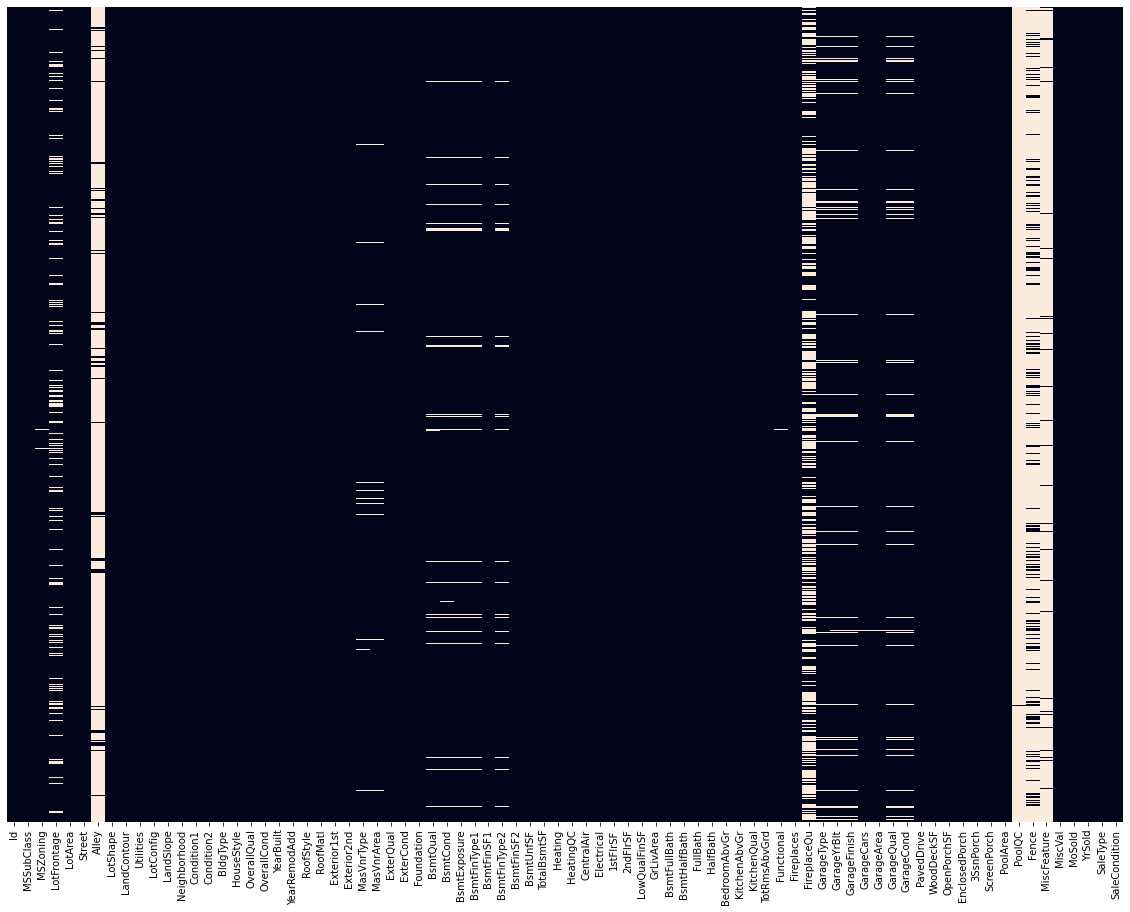

In [32]:
check_for_nulls(test_data_raw)

In [33]:


test_data = preprocessing(test_data_raw,"p")
test_data

,Id,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,MSZoning_A,MSZoning_C,MSZoning_FV,MSZoning_I,MSZoning_RH,MSZoning_RL,MSZoning_RP,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Lvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,Utilities_AllPub,Utilities_NoSewr,Utilities_NoSeWa,Utilities_ELO,LotConfig_LotConfig,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_Names,Neighborhood_NoRidge,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_RRNn,Condition1_RRAn,Condition1_PosN,Condition1_PosA,Condition1_RRNe,Condition1_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_RRNn,Condition2_RRAn,Condition2_PosN,Condition2_PosA,Condition2_RRNe,Condition2_RRAe,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_CBlock,MasVnrType_notIncluded,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_SBrk,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_notIncluded,Fence_GdPrv,Fence_MnPrv,Fence_GdWo,Fence_MnWw,Fence_notIncluded,MiscFeature_Elev,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_notIncluded,SaleType_WD,SaleType_CWD,SaleType_VWD,SaleType_New,SaleType_COD,SaleType_Con,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,1461,20,80.0,11622,2.0,0.0,0.0,5,6,1961,1961,0.0,2.0,2.0,2.0,2.0,3.0,3.0,468.0,4.0,144.0,270.0,882.0,2.0,0.0,896,0,0,896,0.0,0.0,1,0,2,1,2.0,5,0.0,0,5.0,1961.000000,2.0,1.0,730.0,2.0,2.0,0.0,140,0,0,0,120,0,4.

In [34]:
# test_data = feature_selecting(test_data,good_columns)
test_data_id = test_data['Id']

In [35]:
# pred_score = regressor.predict(test_data.drop('Id', axis=1))
pred_score = regressor.predict(test_data)

pred_score

array([119044.60199079, 153621.56764667, 178502.53819848, ...,
       172986.70762927, 113856.16777433, 225849.86746402])

In [36]:
# record your progress with the model
from datetime import datetime

file1 = open("scoring.txt","a")#append mode
message = str(datetime.now().date()) + "\n Training Score " + str(train_score) + "\n Test Score " + str(test_score) +  "\n Corrilation Value " + str(corr_val) + "\n \n"
file1.write(message)
file1.close()

# Kaggle

In [37]:
w = pd.DataFrame(data=test_data['Id'], columns=["Id"])
p = pd.DataFrame(pred_score,columns=["SalePrice"])
w["SalePrice"]=p['SalePrice'].values

final_submission = w
final_submission 

,Id,SalePrice
0,1461,119044.601991
1,1462,153621.567647
2,1463,178502.538198
3,1464,182564.889392
4,1465,221601.098237
...,...,...
1427,2915,85045.230992
1428,2916,71060.055237
1429,2917,172986.707629
1430,2918,113856.167774


In [38]:
final_submission.to_csv("submission.csv",index=False)

# Shap

In [39]:
import shap

In [40]:
sample_X = X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

In [41]:
shap_regressor = LinearRegression().fit(X, y)

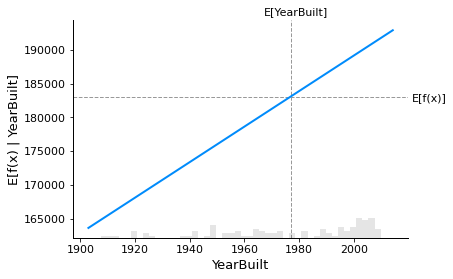

In [42]:
shap.plots.partial_dependence(
    "YearBuilt", shap_regressor.predict, sample_X, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [43]:
explainer = shap.Explainer(regressor.predict, X)
shap_values = explainer(X)
sample_ind = 18

Permutation explainer: 1452it [00:58, 21.28it/s]                          


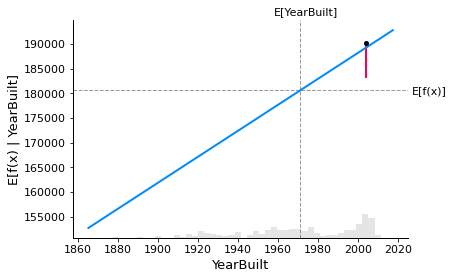

In [44]:
# make a standard partial dependence plot
shap.partial_dependence_plot(
    "YearBuilt", shap_regressor.predict, X, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

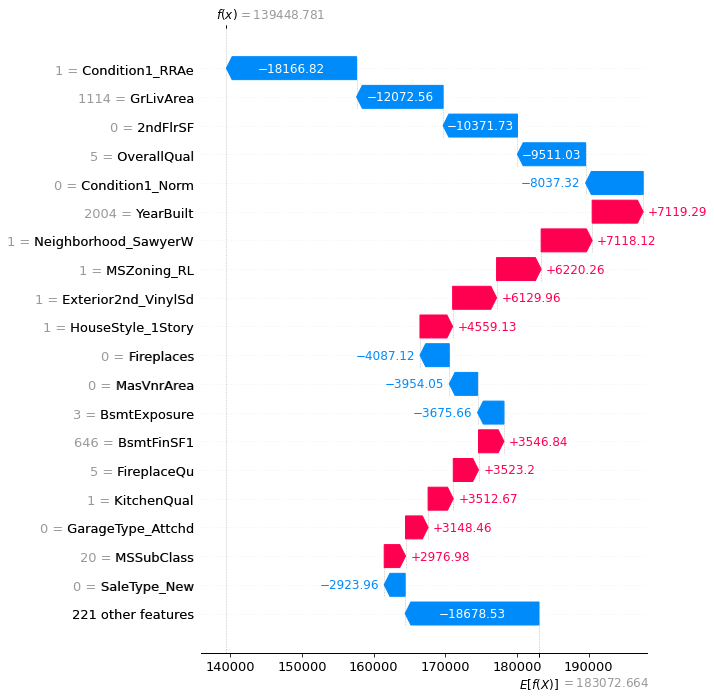

In [45]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=20)

In [46]:
import interpret.glassbox

In [50]:
sample_X = X10 = shap.utils.sample(X, 10) # 100 instances for use as the background distribution

In [51]:
# fit a GAM model to the data
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X10)
shap_values_ebm = explainer_ebm(X)

Permutation explainer:   5%|▌         | 76/1451 [00:52<18:28,  1.24it/s]

Permutation explainer: 1452it [15:39,  1.53it/s]                          


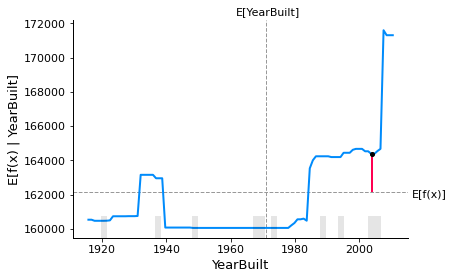

In [93]:
# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "YearBuilt", model_ebm.predict, X10, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

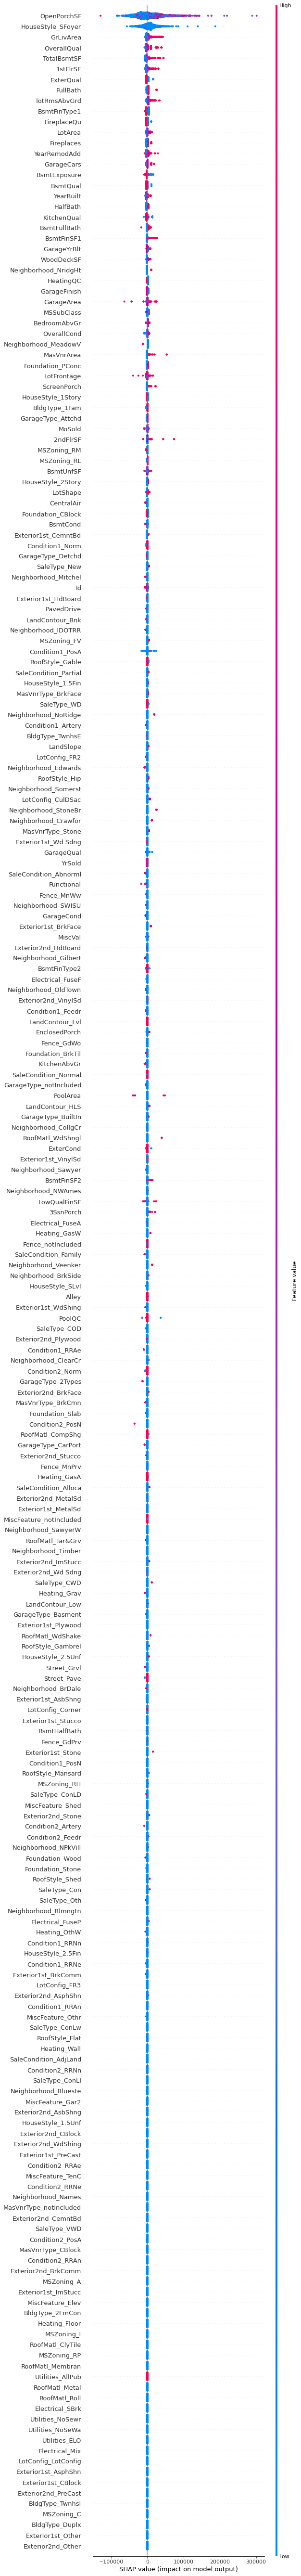

In [97]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm, max_display=240)

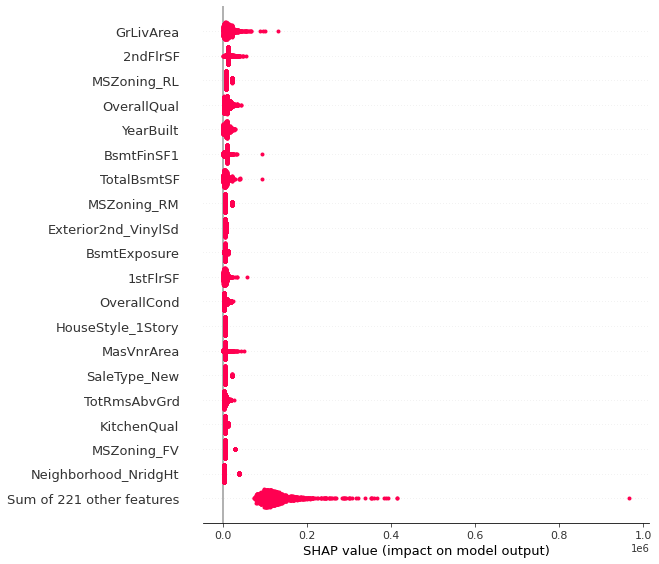

In [49]:
shap.plots.beeswarm(shap_values.abs, color="shap_red", max_display=20)

<p style="text-align: center;">at the end of the day remember...</p>

<H1 style="text-align: center;">Lots of struggle, Plenty of progress</H1>

<H3 style="text-align: center;">“IF THERE IS NO STRUGGLE, THERE IS NO PROGRESS” - FREDERICK DOUGLASS
</H3>
